In [1]:
import pandas as pd
import requests
from os import listdir
from datetime import datetime, timedelta, date
import numpy as np
from scipy.stats import pearsonr
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
from sklearn.linear_model import LinearRegression
pd.set_option('display.max_columns', None)

C:\Users\Dell\AppData\Roaming\Python\Python39\site-packages\statsmodels\compat\pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


From previous analysis, we have found that hourly data correpsonds to the best correlation amongst different asset type so we will proceed with using the hourly data collected in the previous section for analysis

In [2]:
dir_tokens = listdir('Datasets/hour pricing')
lst_of_tokens = list(filter(lambda x: '.csv' in x, dir_tokens))
print(lst_of_tokens)

['ADA-PERP_hour_pricing.csv', 'AVAX-PERP_hour_pricing.csv', 'BNB-PERP_hour_pricing.csv', 'BTC-PERP_hour_pricing.csv', 'CEL-PERP_hour_pricing.csv', 'CHZ-PERP_hour_pricing.csv', 'CRV-PERP_hour_pricing.csv', 'DOGE-PERP_hour_pricing.csv', 'DOT-PERP_hour_pricing.csv', 'ETC-PERP_hour_pricing.csv', 'ETH-PERP_hour_pricing.csv', 'LINK-PERP_hour_pricing.csv', 'MATIC-PERP_hour_pricing.csv', 'NEAR-PERP_hour_pricing.csv', 'SOL-PERP_hour_pricing.csv']


In [4]:
df_dct = {}
for pathes in lst_of_tokens:
    name = pathes.split('_')[0]
    df_dct[name] = pd.read_csv(f'Datasets/hour pricing/{pathes}')

In [5]:
df_overall = df_dct['BTC-PERP'][['startTime', 'open']]
df_overall.columns = ['startTime', 'BTC_price']
for key, value in df_dct.items():
    if key == 'BTC-PERP':
        continue
    else:
        name = key.split('-')[0]
        temp_price_df = value[['startTime', 'open']]
        temp_price_df.columns = ['startTime', f'{name}_price']
        df_overall = df_overall.merge(temp_price_df, how = 'inner', on = 'startTime')
df_overall.head(3)

,startTime,BTC_price,ADA_price,AVAX_price,BNB_price,CEL_price,CHZ_price,CRV_price,DOGE_price,DOT_price,ETC_price,ETH_price,LINK_price,MATIC_price,NEAR_price,SOL_price
0,2021-06-10T07:00:00+00:00,36792.0,1.569295,14.652,363.4575,7.1320,0.237648,2.42490,0.334628,23.831,59.9240,2542.2,24.4545,1.452813,3.153,42.2000
1,2021-06-10T08:00:00+00:00,36997.0,1.574700,14.690,365.3700,7.1690,0.236667,2.44295,0.335948,23.997,60.3375,2549.8,24.5660,1.454710,3.196,42.1625
2,2021-06-10T09:00:00+00:00,36441.0,1.548480,14.368,356.4250,7.1935,0.233613,2.36865,0.332898,23.383,58.7660,2513.8,23.9630,1.412758,3.107,41.4775


In [6]:
df_overall.drop(columns=['startTime','CEL_price'], inplace=True)

Note - We remove **CEL** here because of its recent abnormal price fluctuations due to macro environment

### Correlation

<AxesSubplot:>

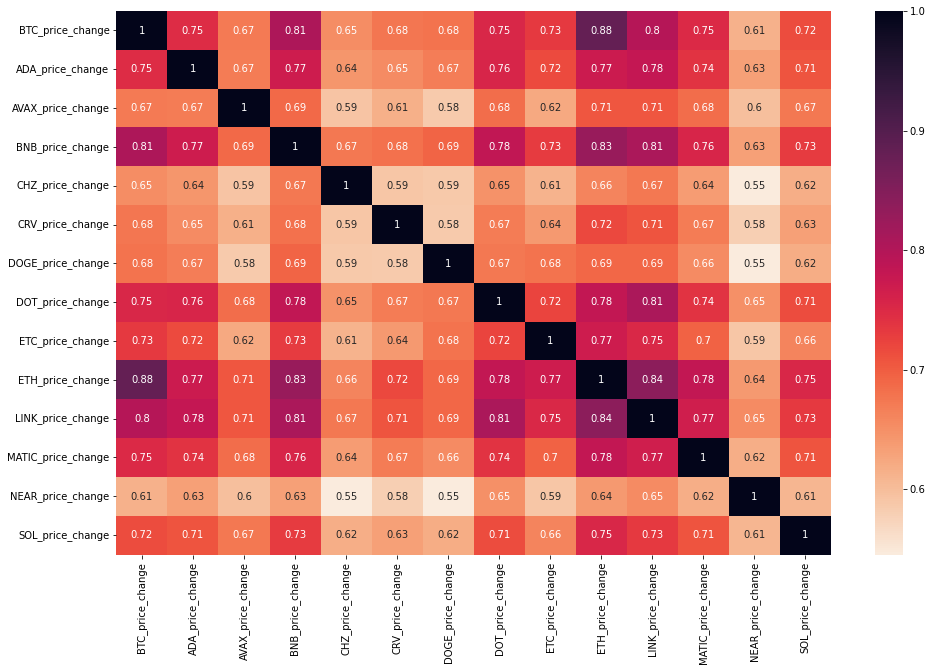

In [7]:
active_top_15_hour_price_change = pd.DataFrame()
price_col_names = list(df_overall.columns)
for name in price_col_names:
    active_top_15_hour_price_change[f'{name}_change'] = pd.Series(df_overall[name].pct_change(1))[1:]

plt.figure(figsize=(16, 10))
sns.heatmap(active_top_15_hour_price_change.corr(), annot = True, cmap = sns.cm.rocket_r)

### Cointegration

[('ADA_price', 'DOGE_price'), ('BNB_price', 'ETH_price'), ('BNB_price', 'SOL_price'), ('DOGE_price', 'LINK_price')]


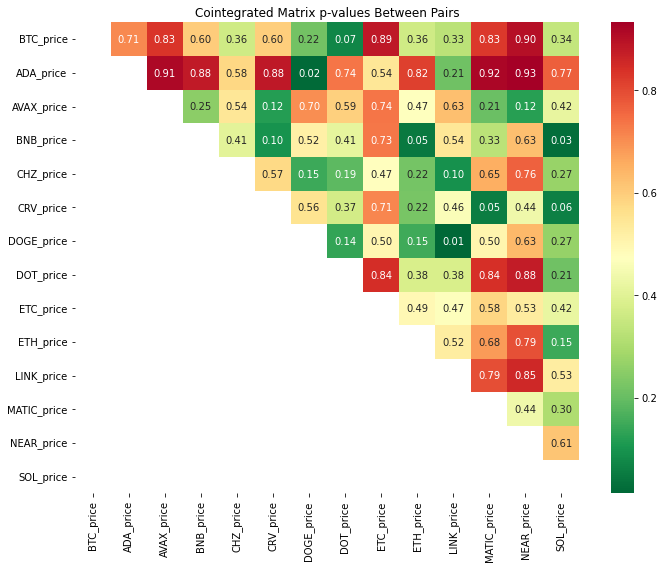

In [8]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            result = coint(data[keys[i]], data[keys[j]])
            pvalue_matrix[i, j] = result[1]
            if result[1] < 0.05:
                pairs.append((keys[i], keys[j]))
    return pvalue_matrix, pairs
pvalues, pairs = find_cointegrated_pairs(df_overall)
print(pairs)
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(pvalues, xticklabels = df_overall.columns, yticklabels = df_overall.columns, cmap = 'RdYlGn_r', annot = True, fmt=".2f", mask = (pvalues >= 0.99))
ax.set_title('Cointegrated Matrix p-values Between Pairs')
plt.tight_layout()

We will select pairs **BNB-ETH** due to its strong cointegration (p-value <= 0.05) and strong correlation 0.83

# Selection of assets to compare 

## BNB vs ETH

### Splitting into train and test dataset

In [56]:
# eth_bnb_df = df_overall[['ETH_price','BNB_price']]
bnb_df = df_dct['BNB-PERP'][['startTime', 'open']]
eth_df = df_dct['ETH-PERP'][['startTime', 'open']]
eth_bnb_df = bnb_df.merge(eth_df, on = 'startTime', how = 'inner')
eth_bnb_df.columns = ['startTime','BNB_price','ETH_price']
breakpoint = round(eth_bnb_df.shape[0]*0.95)
train_df = eth_bnb_df.iloc[:breakpoint,]
test_df = eth_bnb_df.iloc[breakpoint:,]
test_df.reset_index(inplace=True)
train_df.columns = ['startTime','BNB_price','ETH_price']

In [57]:
print(f"Correlation of train set is: {round(train_df[['BNB_price', 'ETH_price']].corr().iloc[1,0],3)}")

def cointegration_value(data):
    n = data.shape[1]
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    for i in range(n):
        for j in range(i+1, n):
            result = coint(data[keys[i]], data[keys[j]])
            pvalue_matrix[i, j] = result[1]
    return pvalue_matrix
print(f"Cointegtation value of train set is: {round(cointegration_value(train_df[['BNB_price', 'ETH_price']].iloc[:breakpoint,])[0,1], 4)}")

Correlation of train set is: 0.963
Cointegtation value of train set is: 0.1129


Note - Train and test set still reflects good correlation and a low p-value suggest that the 2 assets are cointegrated

### Stationary test for BNB-ETH Pair

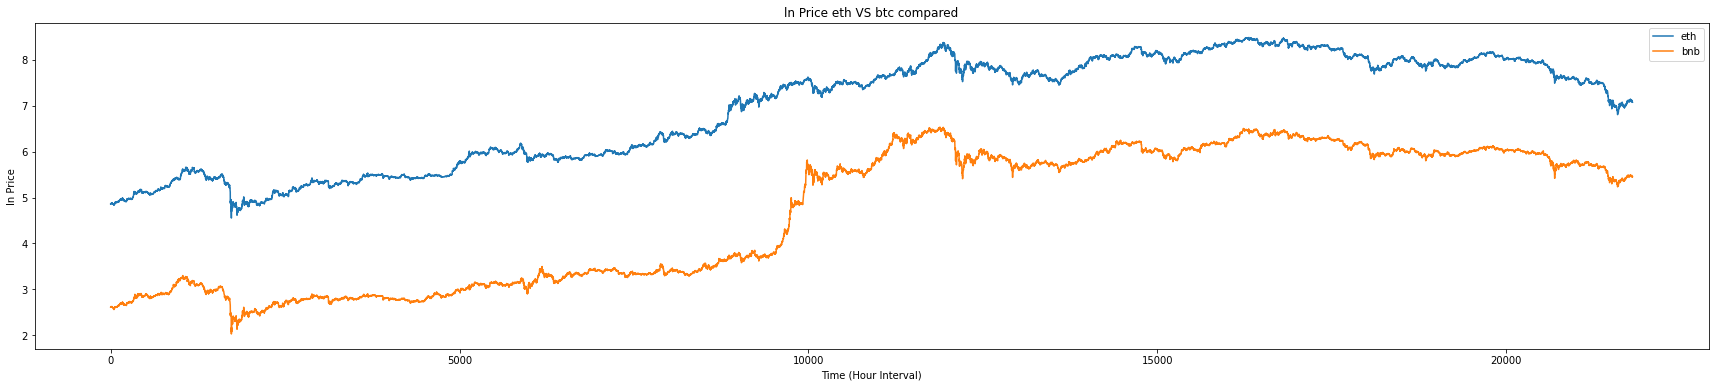

In [58]:
x = range(0,breakpoint) 
y1 = train_df.loc[:,'ETH_price'].apply(lambda x: np.log(x))
y2 = train_df.loc[:,'BNB_price'].apply(lambda x: np.log(x))
plt.figure(figsize=(30, 6))
plt.plot(x, y1, label = "eth")
plt.plot(x, y2, label = "bnb")
plt.legend()
plt.xlabel('Time (Hour Interval)')
plt.ylabel('ln Price')
plt.title('ln Price eth VS btc compared')
plt.show()

Note - Prices between BNB and ETH moves quite similarly on the hour timeframe

In [59]:
# X = np.array(list(train_df['BNB_price'])).reshape(10328,1)
# y = np.array(list(train_df['ETH_price']))
# lr = LinearRegression().fit(X,y)
X = train_df['BNB_price']
y = train_df['ETH_price']

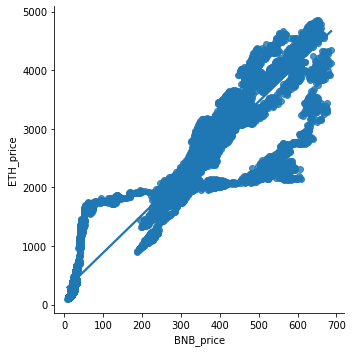

In [60]:
sns.lmplot(x = 'BNB_price', y = 'ETH_price', data = train_df,  y_jitter=.3)

Hedge Ratio is  7.026602


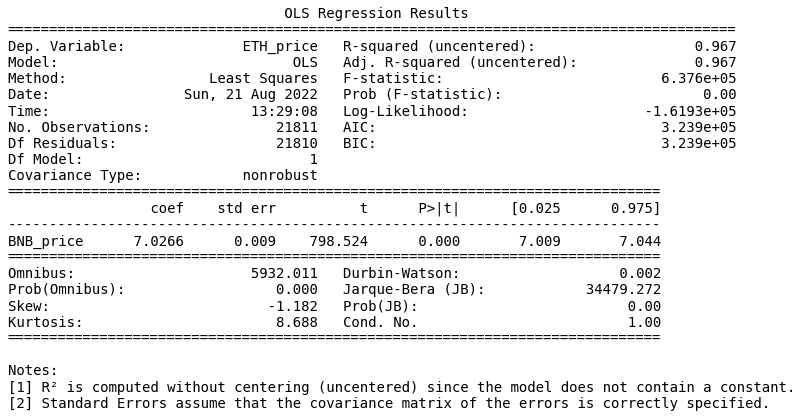

In [61]:
# run OLS regression
import statsmodels.api as sm
model=sm.OLS(y, X).fit()

plt.text(0.01, 0.05, str(model.summary()), {"fontsize": 14}, fontproperties = 'monospace')
plt.axis('off')
plt.subplots_adjust(left=0.1, right=0.2, top=0.2, bottom=0.1)
print('Hedge Ratio is ', round(model.params[0],6))

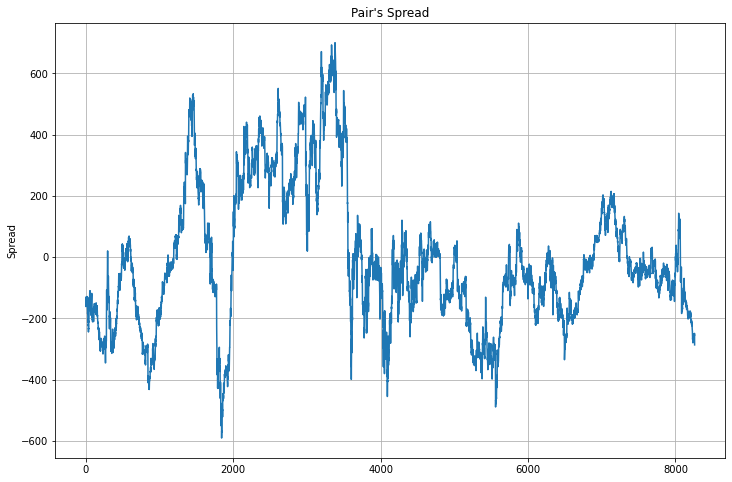

In [103]:
spread = y - model.params[0] * X

plt.figure(figsize=(12, 8))
plt.plot(spread)
plt.title("Pair's Spread")
plt.ylabel("Spread")
plt.grid(True)

### Building trading model

C:\Users\Dell\AppData\Local\Temp/ipykernel_8492/2179638564.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  signals.head(3).append(signals.tail(3))


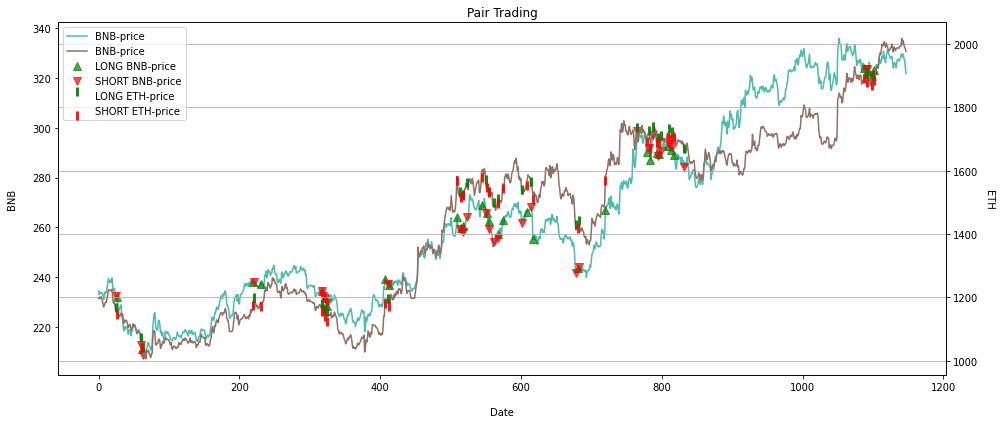

In [63]:
# calculate z-score
def zscore(series_1):
 return (series_1 - series_1.mean()) / np.std(series_1)

# create a dataframe for trading signals
signals = pd.DataFrame()
signals['asset1'] = test_df['BNB_price'] 
signals['asset2'] = test_df["ETH_price"]
ratios = signals.asset1 / signals.asset2

# calculate z-score and define upper and lower thresholds
signals['z'] = zscore(ratios)
signals['z upper limit'] = np.mean(signals['z']) + np.std(signals['z'])
signals['z lower limit'] = np.mean(signals['z']) - np.std(signals['z'])

# create signal - short if z-score is greater than upper limit else long
signals['signals1'] = 0
signals['signals1'] = np.select([signals['z'] > \
                                 signals['z upper limit'], signals['z'] < signals['z lower limit']], [-1, 1], default=0)

# we take the first order difference to obtain portfolio position in that stock
signals['positions1'] = signals['signals1'].diff()
signals['signals2'] = -signals['signals1']
signals['positions2'] = signals['signals2'].diff()

# verify datafame head and tail
signals.head(3).append(signals.tail(3))

# visualize trading signals and position
fig=plt.figure(figsize=(14,6))
bx = fig.add_subplot(111)   
bx2 = bx.twinx()

#plot two different assets
l1, = bx.plot(signals['asset1'], c='#4abdac')
l2, = bx2.plot(signals['asset2'], c='#907163')
u1, = bx.plot(signals['asset1'][signals['positions1'] == 1], lw=0, marker='^', markersize=8, c='g',alpha=0.7)
d1, = bx.plot(signals['asset1'][signals['positions1'] == -1], lw=0,marker='v',markersize=8, c='r',alpha=0.7)
u2, = bx2.plot(signals['asset2'][signals['positions2'] == 1], lw=0,marker=2,markersize=9, c='g',alpha=0.9, markeredgewidth=3)
d2, = bx2.plot(signals['asset2'][signals['positions2'] == -1], lw=0,marker=3,markersize=9, c='r',alpha=0.9,markeredgewidth=3)
bx.set_ylabel('BNB',)
bx2.set_ylabel('ETH', rotation=270)
bx.yaxis.labelpad=15
bx2.yaxis.labelpad=15
bx.set_xlabel('Date')
bx.xaxis.labelpad=15
plt.legend([l1,l2,u1,d1,u2,d2], ['BNB-price', 'BNB-price','LONG {}'.format('BNB-price'),
           'SHORT {}'.format('BNB-price'),
           'LONG {}'.format('ETH-price'),
           'SHORT {}'.format('ETH-price')], loc ='best')
plt.title('Pair Trading')
plt.xlabel('Date')
plt.grid(True)

plt.tight_layout()

Number of days =  1145
CAGR = 1.981%


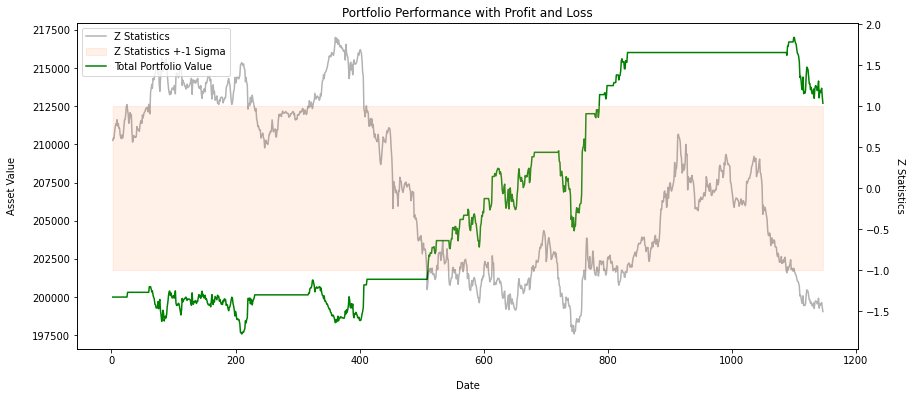

In [64]:
# initial capital to calculate the actual pnl
initial_capital = 100000

# shares to buy for each position
positions1 = initial_capital// max(signals['asset1'])
positions2 = initial_capital// max(signals['asset2'])

# since there are two assets, we calculate each asset Pnl 
# separately and in the end we aggregate them into one portfolio
portfolio = pd.DataFrame()
portfolio['asset1'] = signals['asset1']
portfolio['holdings1'] = signals['positions1'].cumsum() * signals['asset1'] * positions1
portfolio['cash1'] = initial_capital - (signals['positions1'] * signals['asset1'] * positions1).cumsum()
portfolio['total asset1'] = portfolio['holdings1'] + portfolio['cash1']
portfolio['return1'] = portfolio['total asset1'].pct_change()
portfolio['positions1'] = signals['positions1']

# pnl for the 2nd asset
portfolio['asset2'] = signals['asset2']
portfolio['holdings2'] = signals['positions2'].cumsum() * signals['asset2'] * positions2
portfolio['cash2'] = initial_capital - (signals['positions2'] * signals['asset2'] * positions2).cumsum()
portfolio['total asset2'] = portfolio['holdings2'] + portfolio['cash2']
portfolio['return2'] = portfolio['total asset2'].pct_change()
portfolio['positions2'] = signals['positions2']

# total pnl and z-score
portfolio['z'] = signals['z']
portfolio['total asset'] = portfolio['total asset1'] + portfolio['total asset2']
portfolio['z upper limit'] = signals['z upper limit']
portfolio['z lower limit'] = signals['z lower limit']
portfolio = portfolio.dropna()

# plot the asset value change of the portfolio and pnl along with z-score
fig = plt.figure(figsize=(14,6),)
ax = fig.add_subplot(111)
ax2 = ax.twinx()
l1, = ax.plot(portfolio['total asset'], c='g')
l2, = ax2.plot(portfolio['z'], c='black', alpha=0.3)
b = ax2.fill_between(portfolio.index,portfolio['z upper limit'],\
                portfolio['z lower limit'], \
                alpha=0.2,color='#ffb48f')
ax.set_ylabel('Asset Value')
ax2.set_ylabel('Z Statistics',rotation=270)
ax.yaxis.labelpad=15
ax2.yaxis.labelpad=15
ax.set_xlabel('Date')
ax.xaxis.labelpad=15
plt.title('Portfolio Performance with Profit and Loss')
plt.legend([l2,b,l1],['Z Statistics',
                      'Z Statistics +-1 Sigma',
                      'Total Portfolio Value'],loc='upper left');

# calculate CAGR
final_portfolio = portfolio['total asset'].iloc[-1]
delta = (portfolio.index[-1] - portfolio.index[0])
print('Number of days = ', delta)
YEAR_DAYS = 365
returns = (final_portfolio/(initial_capital*2)) ** (YEAR_DAYS/delta) - 1
print('CAGR = {:.3f}%' .format(returns * 100))

In [70]:
win = sum(portfolio['total asset'].pct_change() > 0)
lost = sum(portfolio['total asset'].pct_change() < 0)
win_rate = round(100 * win/(win+lost),3)
print(f'Win rate for pair is {win_rate}%')

Win rate for pair is 51.176%


## BNB vs SOL

In [34]:
sol_bnb_df = df_overall[['SOL_price','BNB_price']]
# bnb_df = df_dct['BNB-PERP'][['startTime', 'open']]
# sol_df = df_dct['SOL-PERP'][['startTime', 'open']]
# sol_bnb_df = bnb_df.merge(sol_df, on = 'startTime', how = 'inner')
# sol_bnb_df.columns = ['startTime','BNB_price','SOL_price']
breakpoint = round(sol_bnb_df.shape[0]*0.95)
train_df = sol_bnb_df.iloc[:breakpoint,]
test_df = sol_bnb_df.iloc[breakpoint:,]
test_df.reset_index(inplace=True)
# train_df.columns = ['startTime','BNB_price','SOL_price']

In [35]:
print(f"Correlation of train set is: {round(train_df[['BNB_price', 'SOL_price']].corr().iloc[1,0],3)}")

def cointegration_value(data):
    n = data.shape[1]
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    for i in range(n):
        for j in range(i+1, n):
            result = coint(data[keys[i]], data[keys[j]])
            pvalue_matrix[i, j] = result[1]
    return pvalue_matrix
print(f"Cointegtation value of train set is: {round(cointegration_value(train_df[['BNB_price', 'SOL_price']].iloc[:breakpoint,])[0,1], 4)}")

Correlation of train set is: 0.9
Cointegtation value of train set is: 0.0403


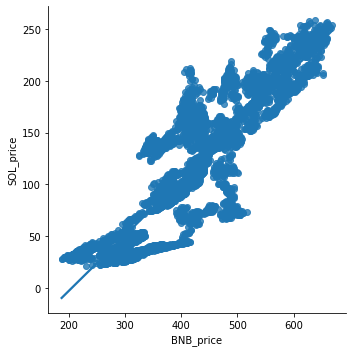

In [36]:
sns.lmplot(x = 'BNB_price', y = 'SOL_price', data = train_df,  y_jitter=.3)

Hedge Ratio is  0.278699


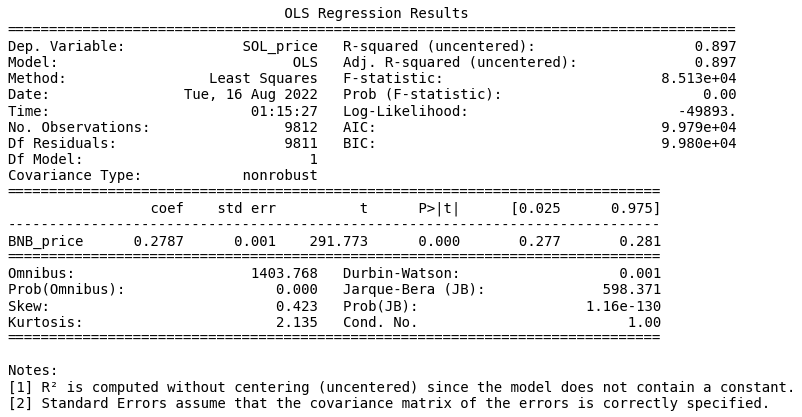

In [152]:
X = train_df['BNB_price']
y = train_df['SOL_price']
# run OLS regression
import statsmodels.api as sm
model=sm.OLS(y, X).fit()

plt.text(0.01, 0.05, str(model.summary()), {"fontsize": 14}, fontproperties = 'monospace')
plt.axis('off')
plt.subplots_adjust(left=0.1, right=0.2, top=0.2, bottom=0.1)
print('Hedge Ratio is ', round(model.params[0],6))

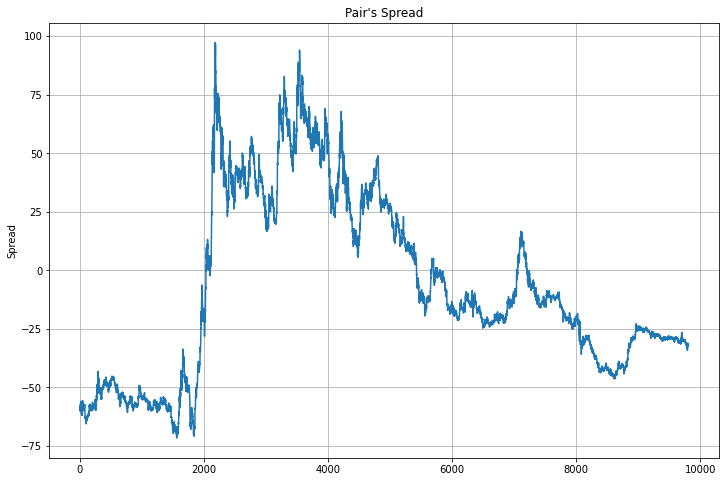

In [153]:
spread = y - model.params[0] * X

plt.figure(figsize=(12, 8))
plt.plot(spread)
plt.title("Pair's Spread")
plt.ylabel("Spread")
plt.grid(True)

C:\Users\Dell\AppData\Local\Temp/ipykernel_8492/4205523440.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  signals.head(3).append(signals.tail(3))


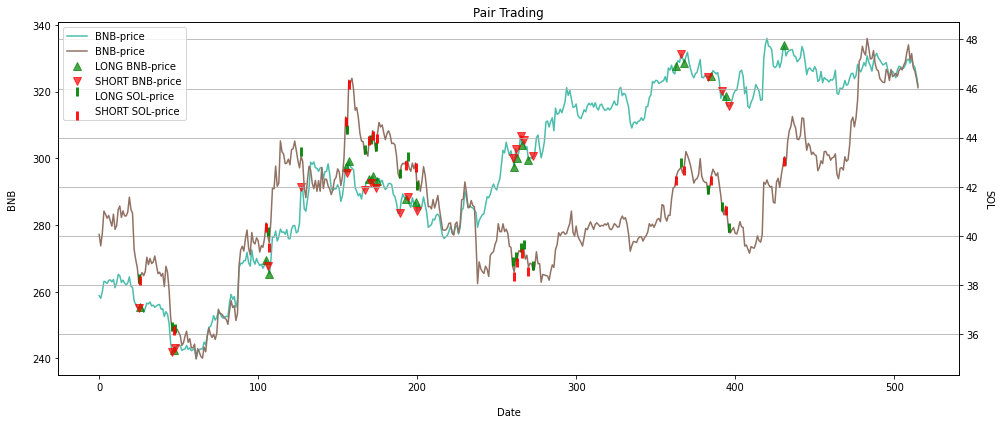

In [37]:
# calculate z-score
def zscore(series_1):
 return (series_1 - series_1.mean()) / np.std(series_1)

# create a dataframe for trading signals
signals = pd.DataFrame()
signals['asset1'] = test_df['BNB_price'] 
signals['asset2'] = test_df["SOL_price"]
ratios = signals.asset1 / signals.asset2

# calculate z-score and define upper and lower thresholds
signals['z'] = zscore(ratios)
signals['z upper limit'] = np.mean(signals['z']) + np.std(signals['z'])
signals['z lower limit'] = np.mean(signals['z']) - np.std(signals['z'])

# create signal - short if z-score is greater than upper limit else long
signals['signals1'] = 0
signals['signals1'] = np.select([signals['z'] > \
                                 signals['z upper limit'], signals['z'] < signals['z lower limit']], [-1, 1], default=0)

# we take the first order difference to obtain portfolio position in that stock
signals['positions1'] = signals['signals1'].diff()
signals['signals2'] = -signals['signals1']
signals['positions2'] = signals['signals2'].diff()

# verify datafame head and tail
signals.head(3).append(signals.tail(3))

# visualize trading signals and position
fig=plt.figure(figsize=(14,6))
bx = fig.add_subplot(111)   
bx2 = bx.twinx()

#plot two different assets
l1, = bx.plot(signals['asset1'], c='#4abdac')
l2, = bx2.plot(signals['asset2'], c='#907163')
u1, = bx.plot(signals['asset1'][signals['positions1'] == 1], lw=0, marker='^', markersize=8, c='g',alpha=0.7)
d1, = bx.plot(signals['asset1'][signals['positions1'] == -1], lw=0,marker='v',markersize=8, c='r',alpha=0.7)
u2, = bx2.plot(signals['asset2'][signals['positions2'] == 1], lw=0,marker=2,markersize=9, c='g',alpha=0.9, markeredgewidth=3)
d2, = bx2.plot(signals['asset2'][signals['positions2'] == -1], lw=0,marker=3,markersize=9, c='r',alpha=0.9,markeredgewidth=3)
bx.set_ylabel('BNB',)
bx2.set_ylabel('SOL', rotation=270)
bx.yaxis.labelpad=15
bx2.yaxis.labelpad=15
bx.set_xlabel('Date')
bx.xaxis.labelpad=15
plt.legend([l1,l2,u1,d1,u2,d2], ['BNB-price', 'BNB-price','LONG {}'.format('BNB-price'),
           'SHORT {}'.format('BNB-price'),
           'LONG {}'.format('SOL-price'),
           'SHORT {}'.format('SOL-price')], loc ='best')
plt.title('Pair Trading')
plt.xlabel('Date')
plt.grid(True)

plt.tight_layout()

Number of days =  513
CAGR = 4.911%


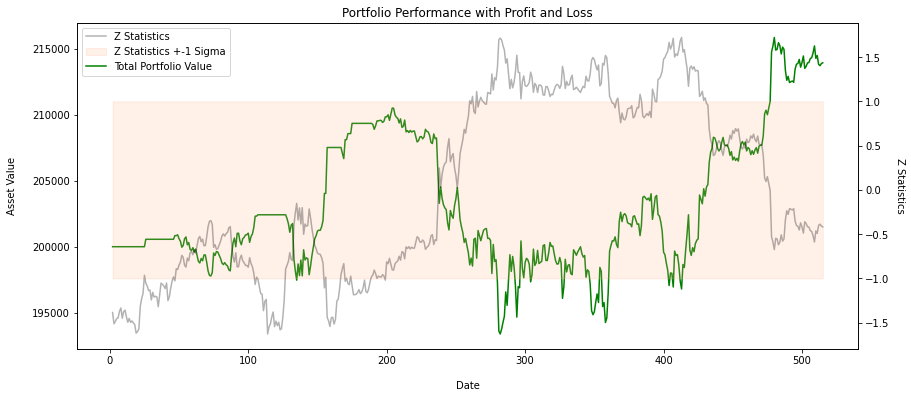

In [38]:
# initial capital to calculate the actual pnl
initial_capital = 100000

# shares to buy for each position
positions1 = initial_capital// max(signals['asset1'])
positions2 = initial_capital// max(signals['asset2'])

# since there are two assets, we calculate each asset Pnl 
# separately and in the end we aggregate them into one portfolio
portfolio = pd.DataFrame()
portfolio['asset1'] = signals['asset1']
portfolio['holdings1'] = signals['positions1'].cumsum() * signals['asset1'] * positions1
portfolio['cash1'] = initial_capital - (signals['positions1'] * signals['asset1'] * positions1).cumsum()
portfolio['total asset1'] = portfolio['holdings1'] + portfolio['cash1']
portfolio['return1'] = portfolio['total asset1'].pct_change()
portfolio['positions1'] = signals['positions1']

# pnl for the 2nd asset
portfolio['asset2'] = signals['asset2']
portfolio['holdings2'] = signals['positions2'].cumsum() * signals['asset2'] * positions2
portfolio['cash2'] = initial_capital - (signals['positions2'] * signals['asset2'] * positions2).cumsum()
portfolio['total asset2'] = portfolio['holdings2'] + portfolio['cash2']
portfolio['return2'] = portfolio['total asset2'].pct_change()
portfolio['positions2'] = signals['positions2']

# total pnl and z-score
portfolio['z'] = signals['z']
portfolio['total asset'] = portfolio['total asset1'] + portfolio['total asset2']
portfolio['z upper limit'] = signals['z upper limit']
portfolio['z lower limit'] = signals['z lower limit']
portfolio = portfolio.dropna()

# plot the asset value change of the portfolio and pnl along with z-score
fig = plt.figure(figsize=(14,6),)
ax = fig.add_subplot(111)
ax2 = ax.twinx()
l1, = ax.plot(portfolio['total asset'], c='g')
l2, = ax2.plot(portfolio['z'], c='black', alpha=0.3)
b = ax2.fill_between(portfolio.index,portfolio['z upper limit'],\
                portfolio['z lower limit'], \
                alpha=0.2,color='#ffb48f')
ax.set_ylabel('Asset Value')
ax2.set_ylabel('Z Statistics',rotation=270)
ax.yaxis.labelpad=15
ax2.yaxis.labelpad=15
ax.set_xlabel('Date')
ax.xaxis.labelpad=15
plt.title('Portfolio Performance with Profit and Loss')
plt.legend([l2,b,l1],['Z Statistics',
                      'Z Statistics +-1 Sigma',
                      'Total Portfolio Value'],loc='upper left');

# calculate CAGR
final_portfolio = portfolio['total asset'].iloc[-1]
delta = (portfolio.index[-1] - portfolio.index[0])
print('Number of days = ', delta)
YEAR_DAYS = 365
returns = (final_portfolio/(initial_capital*2)) ** (YEAR_DAYS/delta) - 1
print('CAGR = {:.3f}%' .format(returns * 100))

In [39]:
win = sum(portfolio['total asset'].pct_change() > 0)
lost = sum(portfolio['total asset'].pct_change() < 0)
win_rate = round(100 * win/(win+lost),3)
print(f'Win rate for pair is {win_rate}%')

Win rate for pair is 51.905%


## ETH vs SOL

In [40]:
sol_df = df_dct['SOL-PERP'][['startTime', 'open']]
eth_df = df_dct['ETH-PERP'][['startTime', 'open']]
eth_sol_df = sol_df.merge(eth_df, on = 'startTime', how = 'inner')
eth_sol_df.columns = ['startTime','SOL_price','ETH_price']
breakpoint = round(eth_sol_df.shape[0]*0.8)
train_df = eth_sol_df.iloc[:breakpoint,]
test_df = eth_sol_df.iloc[breakpoint:,]
test_df.reset_index(inplace=True)
train_df.columns = ['startTime','SOL_price','ETH_price']

In [41]:
print(f"Correlation of train set is: {round(train_df[['ETH_price', 'SOL_price']].corr().iloc[1,0],3)}")

def cointegration_value(data):
    n = data.shape[1]
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    for i in range(n):
        for j in range(i+1, n):
            result = coint(data[keys[i]], data[keys[j]])
            pvalue_matrix[i, j] = result[1]
    return pvalue_matrix
print(f"Cointegtation value of train set is: {round(cointegration_value(train_df[['ETH_price', 'SOL_price']].iloc[:breakpoint,])[0,1], 4)}")

Correlation of train set is: 0.874
Cointegtation value of train set is: 0.3872


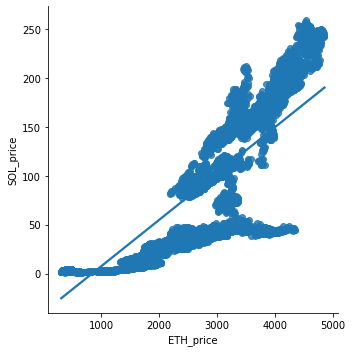

In [42]:
X = train_df['ETH_price']
y = train_df['SOL_price']
sns.lmplot(x = 'ETH_price', y = 'SOL_price', data = train_df,  y_jitter=.3)

Hedge Ratio is  0.033991


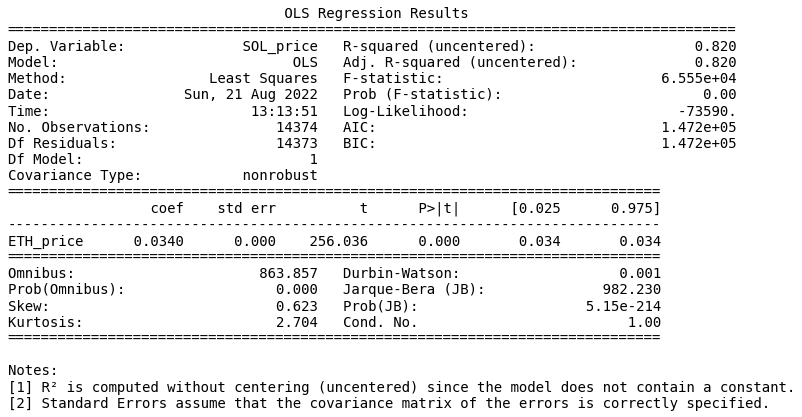

In [43]:
# run OLS regression
import statsmodels.api as sm
model=sm.OLS(y, X).fit()

plt.text(0.01, 0.05, str(model.summary()), {"fontsize": 14}, fontproperties = 'monospace')
plt.axis('off')
plt.subplots_adjust(left=0.1, right=0.2, top=0.2, bottom=0.1)
print('Hedge Ratio is ', round(model.params[0],6))

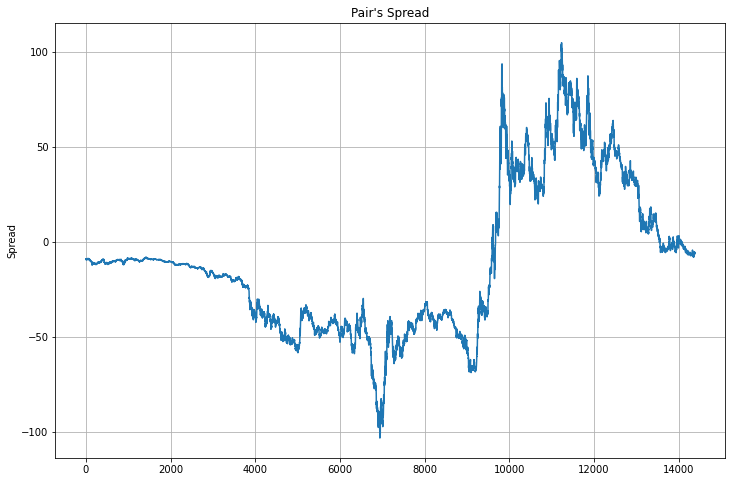

In [44]:
spread = y - model.params[0] * X

plt.figure(figsize=(12, 8))
plt.plot(spread)
plt.title("Pair's Spread")
plt.ylabel("Spread")
plt.grid(True)

C:\Users\Dell\AppData\Local\Temp/ipykernel_8492/1005459215.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  signals.head(3).append(signals.tail(3))


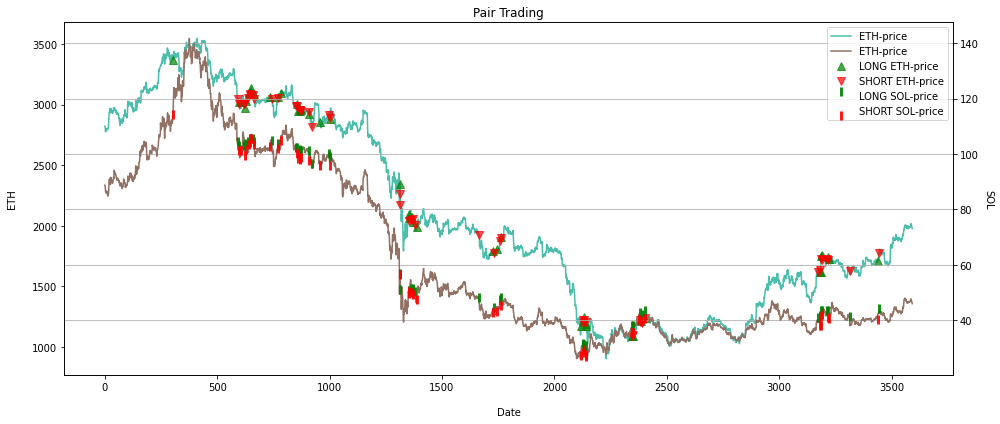

In [45]:
# calculate z-score
def zscore(series_1):
 return (series_1 - series_1.mean()) / np.std(series_1)

# create a dataframe for trading signals
signals = pd.DataFrame()
signals['asset1'] = test_df['ETH_price'] 
signals['asset2'] = test_df["SOL_price"]
ratios = signals.asset1 / signals.asset2

# calculate z-score and define upper and lower thresholds
signals['z'] = zscore(ratios)
signals['z upper limit'] = np.mean(signals['z']) + np.std(signals['z'])
signals['z lower limit'] = np.mean(signals['z']) - np.std(signals['z'])

# create signal - short if z-score is greater than upper limit else long
signals['signals1'] = 0
signals['signals1'] = np.select([signals['z'] > \
                                 signals['z upper limit'], signals['z'] < signals['z lower limit']], [-1, 1], default=0)

# we take the first order difference to obtain portfolio position in that stock
signals['positions1'] = signals['signals1'].diff()
signals['signals2'] = -signals['signals1']
signals['positions2'] = signals['signals2'].diff()

# verify datafame head and tail
signals.head(3).append(signals.tail(3))

# visualize trading signals and position
fig=plt.figure(figsize=(14,6))
bx = fig.add_subplot(111)   
bx2 = bx.twinx()

#plot two different assets
l1, = bx.plot(signals['asset1'], c='#4abdac')
l2, = bx2.plot(signals['asset2'], c='#907163')
u1, = bx.plot(signals['asset1'][signals['positions1'] == 1], lw=0, marker='^', markersize=8, c='g',alpha=0.7)
d1, = bx.plot(signals['asset1'][signals['positions1'] == -1], lw=0,marker='v',markersize=8, c='r',alpha=0.7)
u2, = bx2.plot(signals['asset2'][signals['positions2'] == 1], lw=0,marker=2,markersize=9, c='g',alpha=0.9, markeredgewidth=3)
d2, = bx2.plot(signals['asset2'][signals['positions2'] == -1], lw=0,marker=3,markersize=9, c='r',alpha=0.9,markeredgewidth=3)
bx.set_ylabel('ETH',)
bx2.set_ylabel('SOL', rotation=270)
bx.yaxis.labelpad=15
bx2.yaxis.labelpad=15
bx.set_xlabel('Date')
bx.xaxis.labelpad=15
plt.legend([l1,l2,u1,d1,u2,d2], ['ETH-price', 'ETH-price','LONG {}'.format('ETH-price'),
           'SHORT {}'.format('ETH-price'),
           'LONG {}'.format('SOL-price'),
           'SHORT {}'.format('SOL-price')], loc ='best')
plt.title('Pair Trading')
plt.xlabel('Date')
plt.grid(True)

plt.tight_layout()

Number of days =  3590
CAGR = 1.232%


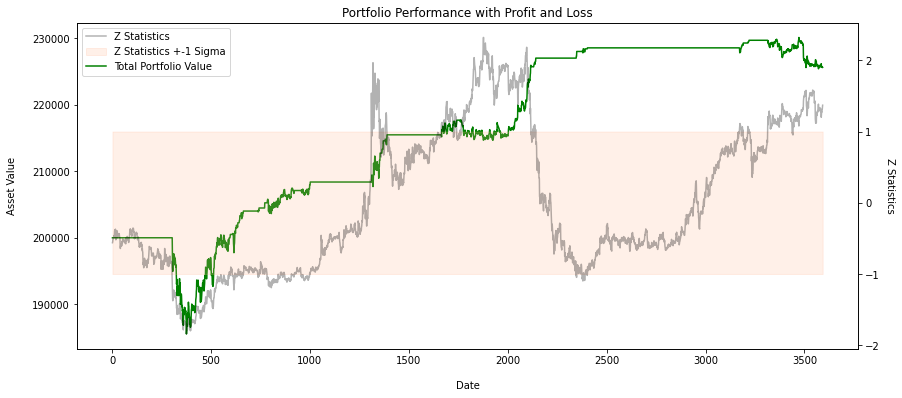

In [46]:
# initial capital to calculate the actual pnl
initial_capital = 100000

# shares to buy for each position
positions1 = initial_capital// max(signals['asset1'])
positions2 = initial_capital// max(signals['asset2'])

# since there are two assets, we calculate each asset Pnl 
# separately and in the end we aggregate them into one portfolio
portfolio = pd.DataFrame()
portfolio['asset1'] = signals['asset1']
portfolio['holdings1'] = signals['positions1'].cumsum() * signals['asset1'] * positions1
portfolio['cash1'] = initial_capital - (signals['positions1'] * signals['asset1'] * positions1).cumsum()
portfolio['total asset1'] = portfolio['holdings1'] + portfolio['cash1']
portfolio['return1'] = portfolio['total asset1'].pct_change()
portfolio['positions1'] = signals['positions1']

# pnl for the 2nd asset
portfolio['asset2'] = signals['asset2']
portfolio['holdings2'] = signals['positions2'].cumsum() * signals['asset2'] * positions2
portfolio['cash2'] = initial_capital - (signals['positions2'] * signals['asset2'] * positions2).cumsum()
portfolio['total asset2'] = portfolio['holdings2'] + portfolio['cash2']
portfolio['return2'] = portfolio['total asset2'].pct_change()
portfolio['positions2'] = signals['positions2']

# total pnl and z-score
portfolio['z'] = signals['z']
portfolio['total asset'] = portfolio['total asset1'] + portfolio['total asset2']
portfolio['z upper limit'] = signals['z upper limit']
portfolio['z lower limit'] = signals['z lower limit']
portfolio = portfolio.dropna()

# plot the asset value change of the portfolio and pnl along with z-score
fig = plt.figure(figsize=(14,6),)
ax = fig.add_subplot(111)
ax2 = ax.twinx()
l1, = ax.plot(portfolio['total asset'], c='g')
l2, = ax2.plot(portfolio['z'], c='black', alpha=0.3)
b = ax2.fill_between(portfolio.index,portfolio['z upper limit'],\
                portfolio['z lower limit'], \
                alpha=0.2,color='#ffb48f')
ax.set_ylabel('Asset Value')
ax2.set_ylabel('Z Statistics',rotation=270)
ax.yaxis.labelpad=15
ax2.yaxis.labelpad=15
ax.set_xlabel('Date')
ax.xaxis.labelpad=15
plt.title('Portfolio Performance with Profit and Loss')
plt.legend([l2,b,l1],['Z Statistics',
                      'Z Statistics +-1 Sigma',
                      'Total Portfolio Value'],loc='upper left');

# calculate CAGR
final_portfolio = portfolio['total asset'].iloc[-1]
delta = (portfolio.index[-1] - portfolio.index[0])
print('Number of days = ', delta)
YEAR_DAYS = 365
returns = (final_portfolio/(initial_capital*2)) ** (YEAR_DAYS/delta) - 1
print('CAGR = {:.3f}%' .format(returns * 100))

In [47]:
win = sum(portfolio['total asset'].pct_change() > 0)
lost = sum(portfolio['total asset'].pct_change() < 0)
win_rate = round(100 * win/(win+lost),3)
print(f'Win rate for pair is {win_rate}%')

Win rate for pair is 50.151%


## Doge VS Link (Bad pair to work on due to the inherent volatility of these particular assets)

In [48]:
# link_df = df_dct['LINK-PERP'][['startTime', 'open']]
# doge_df = df_dct['DOGE-PERP'][['startTime', 'open']]
# doge_link_df = link_df.merge(doge_df, on = 'startTime', how = 'inner')
doge_link_df = df_overall[['LINK_price','DOGE_price']]
# doge_link_df.columns = ['startTime','LINK_price','DOGE_price']
breakpoint = round(doge_link_df.shape[0]*0.9)
train_df = doge_link_df.iloc[:breakpoint,]
test_df = doge_link_df.iloc[breakpoint:,]
test_df.reset_index(inplace=True)

In [49]:
print(f"Correlation of train set is: {round(train_df[['DOGE_price', 'LINK_price']].corr().iloc[1,0],3)}")

def cointegration_value(data):
    n = data.shape[1]
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    for i in range(n):
        for j in range(i+1, n):
            result = coint(data[keys[i]], data[keys[j]])
            pvalue_matrix[i, j] = result[1]
    return pvalue_matrix
print(f"Cointegtation value of train set is: {round(cointegration_value(train_df[['DOGE_price', 'LINK_price']].iloc[:breakpoint,])[0,1], 4)}")

Correlation of train set is: 0.871
Cointegtation value of train set is: 0.0221


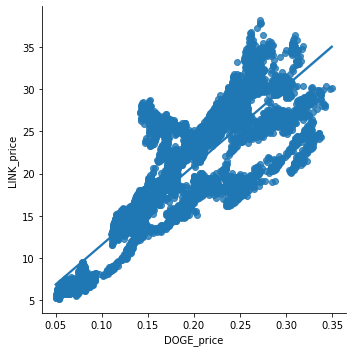

In [50]:
X = train_df['DOGE_price']
y = train_df['LINK_price']
sns.lmplot(x = 'DOGE_price', y = 'LINK_price', data = train_df,  y_jitter=.3)

Hedge Ratio is  104.331337


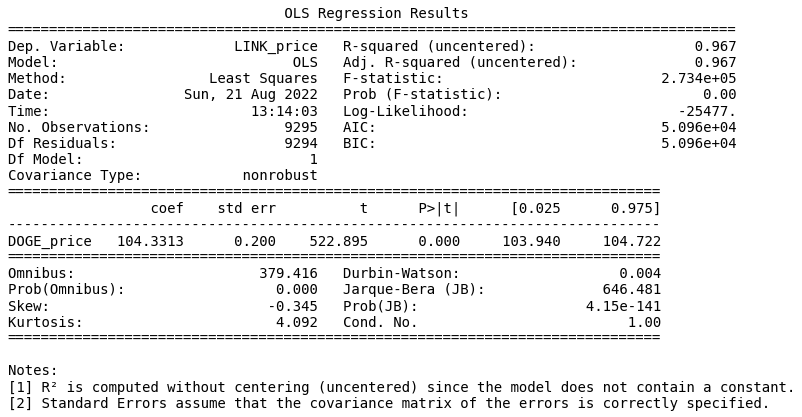

In [51]:
X = train_df['DOGE_price']
y = train_df['LINK_price']
# run OLS regression
import statsmodels.api as sm
model=sm.OLS(y, X).fit()

plt.text(0.01, 0.05, str(model.summary()), {"fontsize": 14}, fontproperties = 'monospace')
plt.axis('off')
plt.subplots_adjust(left=0.1, right=0.2, top=0.2, bottom=0.1)
print('Hedge Ratio is ', round(model.params[0],6))

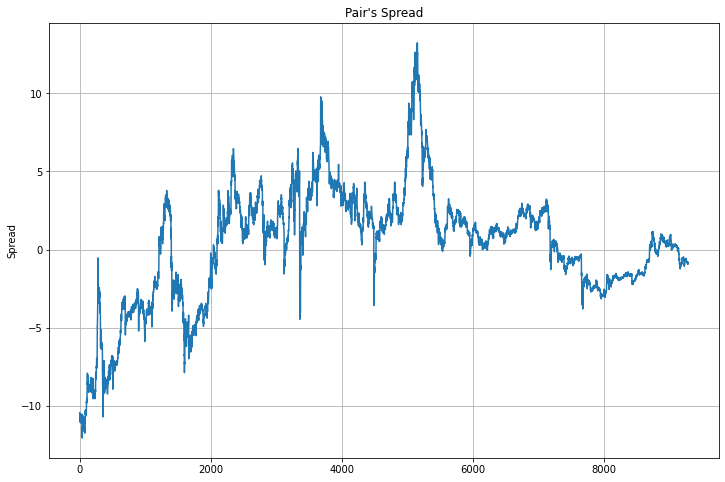

In [52]:
spread = y - model.params[0] * X

plt.figure(figsize=(12, 8))
plt.plot(spread)
plt.title("Pair's Spread")
plt.ylabel("Spread")
plt.grid(True)

C:\Users\Dell\AppData\Local\Temp/ipykernel_8492/4170710781.py:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  signals.head(3).append(signals.tail(3))


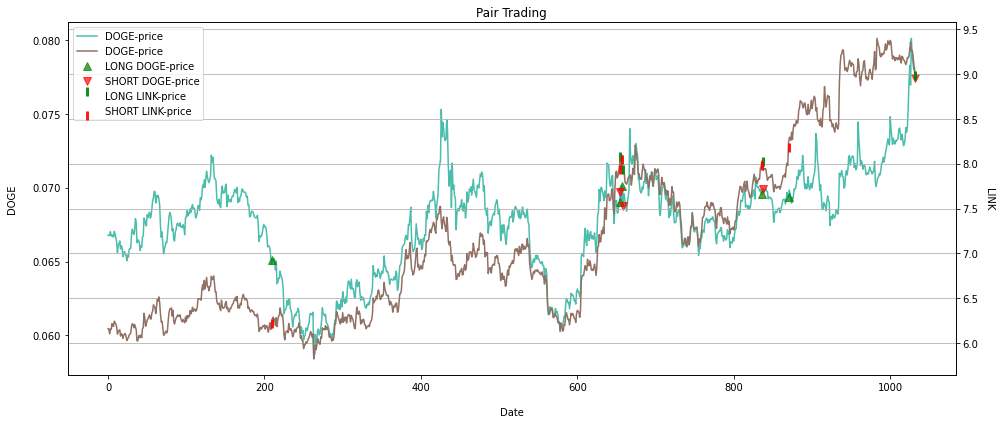

In [53]:
# calculate z-score
def zscore(series_1):
 return (series_1 - series_1.mean()) / np.std(series_1)

# create a dataframe for trading signals
signals = pd.DataFrame()
signals['asset1'] = test_df['DOGE_price'] 
signals['asset2'] = test_df["LINK_price"]
ratios = signals.asset1 / signals.asset2

# calculate z-score and define upper and lower thresholds
signals['z'] = zscore(ratios)
signals['z upper limit'] = np.mean(signals['z']) + np.std(signals['z'])
signals['z lower limit'] = np.mean(signals['z']) - np.std(signals['z'])

# create signal - short if z-score is greater than upper limit else long
signals['signals1'] = 0
signals['signals1'] = np.select([signals['z'] > \
                                 signals['z upper limit'], signals['z'] < signals['z lower limit']], [-1, 1], default=0)

# we take the first order difference to obtain portfolio position in that stock
signals['positions1'] = signals['signals1'].diff()
signals['signals2'] = -signals['signals1']
signals['positions2'] = signals['signals2'].diff()

# verify datafame head and tail
signals.head(3).append(signals.tail(3))

# visualize trading signals and position
fig=plt.figure(figsize=(14,6))
bx = fig.add_subplot(111)   
bx2 = bx.twinx()

#plot two different assets
l1, = bx.plot(signals['asset1'], c='#4abdac')
l2, = bx2.plot(signals['asset2'], c='#907163')
u1, = bx.plot(signals['asset1'][signals['positions1'] == 1], lw=0, marker='^', markersize=8, c='g',alpha=0.7)
d1, = bx.plot(signals['asset1'][signals['positions1'] == -1], lw=0,marker='v',markersize=8, c='r',alpha=0.7)
u2, = bx2.plot(signals['asset2'][signals['positions2'] == 1], lw=0,marker=2,markersize=9, c='g',alpha=0.9, markeredgewidth=3)
d2, = bx2.plot(signals['asset2'][signals['positions2'] == -1], lw=0,marker=3,markersize=9, c='r',alpha=0.9,markeredgewidth=3)
bx.set_ylabel('DOGE',)
bx2.set_ylabel('LINK', rotation=270)
bx.yaxis.labelpad=15
bx2.yaxis.labelpad=15
bx.set_xlabel('Date')
bx.xaxis.labelpad=15
plt.legend([l1,l2,u1,d1,u2,d2], ['DOGE-price', 'DOGE-price','LONG {}'.format('DOGE-price'),
           'SHORT {}'.format('DOGE-price'),
           'LONG {}'.format('LINK-price'),
           'SHORT {}'.format('LINK-price')], loc ='best')
plt.title('Pair Trading')
plt.xlabel('Date')
plt.grid(True)

plt.tight_layout()

Number of days =  1030
CAGR = -1.488%


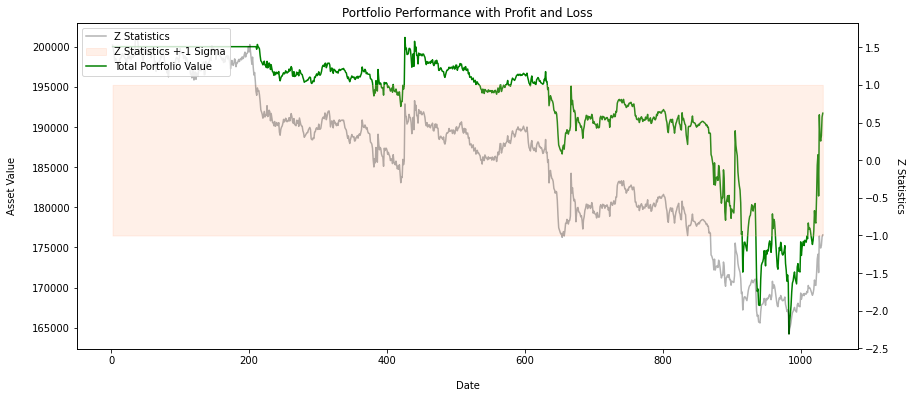

In [54]:
# initial capital to calculate the actual pnl
initial_capital = 100000

# shares to buy for each position
positions1 = initial_capital// max(signals['asset1'])
positions2 = initial_capital// max(signals['asset2'])

# since there are two assets, we calculate each asset Pnl 
# separately and in the end we aggregate them into one portfolio
portfolio = pd.DataFrame()
portfolio['asset1'] = signals['asset1']
portfolio['holdings1'] = signals['positions1'].cumsum() * signals['asset1'] * positions1
portfolio['cash1'] = initial_capital - (signals['positions1'] * signals['asset1'] * positions1).cumsum()
portfolio['total asset1'] = portfolio['holdings1'] + portfolio['cash1']
portfolio['return1'] = portfolio['total asset1'].pct_change()
portfolio['positions1'] = signals['positions1']

# pnl for the 2nd asset
portfolio['asset2'] = signals['asset2']
portfolio['holdings2'] = signals['positions2'].cumsum() * signals['asset2'] * positions2
portfolio['cash2'] = initial_capital - (signals['positions2'] * signals['asset2'] * positions2).cumsum()
portfolio['total asset2'] = portfolio['holdings2'] + portfolio['cash2']
portfolio['return2'] = portfolio['total asset2'].pct_change()
portfolio['positions2'] = signals['positions2']

# total pnl and z-score
portfolio['z'] = signals['z']
portfolio['total asset'] = portfolio['total asset1'] + portfolio['total asset2']
portfolio['z upper limit'] = signals['z upper limit']
portfolio['z lower limit'] = signals['z lower limit']
portfolio = portfolio.dropna()

# plot the asset value change of the portfolio and pnl along with z-score
fig = plt.figure(figsize=(14,6),)
ax = fig.add_subplot(111)
ax2 = ax.twinx()
l1, = ax.plot(portfolio['total asset'], c='g')
l2, = ax2.plot(portfolio['z'], c='black', alpha=0.3)
b = ax2.fill_between(portfolio.index,portfolio['z upper limit'],\
                portfolio['z lower limit'], \
                alpha=0.2,color='#ffb48f')
ax.set_ylabel('Asset Value')
ax2.set_ylabel('Z Statistics',rotation=270)
ax.yaxis.labelpad=15
ax2.yaxis.labelpad=15
ax.set_xlabel('Date')
ax.xaxis.labelpad=15
plt.title('Portfolio Performance with Profit and Loss')
plt.legend([l2,b,l1],['Z Statistics',
                      'Z Statistics +-1 Sigma',
                      'Total Portfolio Value'],loc='upper left');

# calculate CAGR
final_portfolio = portfolio['total asset'].iloc[-1]
delta = (portfolio.index[-1] - portfolio.index[0])
print('Number of days = ', delta)
YEAR_DAYS = 365
returns = (final_portfolio/(initial_capital*2)) ** (YEAR_DAYS/delta) - 1
print('CAGR = {:.3f}%' .format(returns * 100))

In [55]:
win = sum(portfolio['total asset'].pct_change() > 0)
lost = sum(portfolio['total asset'].pct_change() < 0)
win_rate = round(100 * win/(win+lost),3)
print(f'Win rate for pair is {win_rate}%')

Win rate for pair is 46.959%


Note - This is a bad pair noting the volatility of the 2 assets we chose reflecting in poor performance despite the favorable Correlation and cointegration metrics

## Useful links that were directly referenced to develop the accumen and build the model 

* https://datacrushblog.wordpress.com/2016/12/20/statistical-arbitrage-trading-pairs-in-python-using-correlation-cointegration-and-the-engle-granger-approach/ (https://github.com/kmfranz/trading_pairs/blob/master/eda.py)
* https://bsic.it/pairs-trading-building-a-backtesting-environment-with-python/
* https://www.linkedin.com/pulse/statistical-arbitrage-pairs-trading-backtesting-sabir-jana/
* https://blog.quantinsti.com/selection-pairs-statistical-arbitrage-project-divyant-agarwal/